In [1]:
import lcdb

In [2]:
curves = lcdb.get_all_curves()
curves

,openmlid,learner,size_train,size_test,outer_seed,inner_seed,traintime,score_train,score_valid,score_test
0,44,SVC_linear,16,461,0,0,0.0024,0.8750,0.7440,0.7072
1,44,SVC_linear,23,461,0,0,0.0014,0.9565,0.7222,0.6876
2,44,SVC_linear,32,461,0,0,0.0017,0.9375,0.7295,0.7180
3,44,SVC_linear,45,461,0,0,0.0023,0.9778,0.8237,0.8048
4,44,SVC_linear,64,461,0,0,0.0033,0.7812,0.6280,0.6508
...,...,...,...,...,...,...,...,...,...,...
1953366,1464,sklearn.linear_model.SGDClassifier,181,75,4,4,0.0010,0.8011,0.7647,0.7600
1953367,1464,sklearn.linear_model.SGDClassifier,256,75,4,4,0.0012,0.7734,0.7647,0.7600
1953368,1464,sklearn.linear_model.SGDClassifier,362,75,4,4,0.0015,0.7735,0.7647,0.7600
1953369,1464,sklearn.linear_model.SGDClassifier,512,75,4,4,0.0018,0.4395,0.3676,0.4533


In [3]:
curves

,openmlid,learner,size_train,size_test,outer_seed,inner_seed,traintime,score_train,score_valid,score_test
0,44,SVC_linear,16,461,0,0,0.0024,0.8750,0.7440,0.7072
1,44,SVC_linear,23,461,0,0,0.0014,0.9565,0.7222,0.6876
2,44,SVC_linear,32,461,0,0,0.0017,0.9375,0.7295,0.7180
3,44,SVC_linear,45,461,0,0,0.0023,0.9778,0.8237,0.8048
4,44,SVC_linear,64,461,0,0,0.0033,0.7812,0.6280,0.6508
...,...,...,...,...,...,...,...,...,...,...
1953366,1464,sklearn.linear_model.SGDClassifier,181,75,4,4,0.0010,0.8011,0.7647,0.7600
1953367,1464,sklearn.linear_model.SGDClassifier,256,75,4,4,0.0012,0.7734,0.7647,0.7600
1953368,1464,sklearn.linear_model.SGDClassifier,362,75,4,4,0.0015,0.7735,0.7647,0.7600
1953369,1464,sklearn.linear_model.SGDClassifier,512,75,4,4,0.0018,0.4395,0.3676,0.4533


In [4]:
import torch

def vapor_pressure(x, a, b, c):
    return torch.exp(a + b * x + c * torch.log(x + 1))

def pow3(x, a, alpha, c):
    return c - a * torch.pow(x, -alpha)

def log_log_linear(x, a, b):
    a = torch.exp(a)
    b = torch.exp(b)
    return torch.log(a * torch.log(x + 1) + b)

def hill3(x, alpha, beta, kappa, delta):
    kappa = torch.exp(kappa)
    return alpha - beta / (alpha - 1 + torch.pow(kappa * x, delta))

def log_power(x, a, c):
    return c - torch.pow(torch.log(x), a)

def pow4(x, a, b, alpha, c):
    return c - torch.pow(a * x + b, -alpha)

def mmf(x, alpha, beta, kappa, delta):
    return alpha - beta / (alpha - 1 + torch.pow(kappa * x, delta))

def exp4(x, a, b, c):
    return c - torch.exp(-a * x + b)

def janoschek(x, alpha, beta, kappa):
    return alpha - (alpha - beta) * torch.exp(-kappa * x)

def weibull(x, alpha, beta, kappa, delta):
    return alpha - (alpha - beta) * torch.exp(-torch.pow(kappa * x, delta))

def ilog2(x, a, c):
    return c - torch.pow(torch.log(x + 1), a)

In [49]:
model_dict = {
    vapor_pressure: 3,
    pow3: 3,
    log_log_linear: 2,
    hill3: 4,
    log_power: 2,
    pow4: 4,
    mmf: 4,
    exp4: 3,
    janoschek: 3,
    weibull: 4,
    ilog2: 2
}

def combined(x, original_weights, theta):
    x = x.reshape((x.shape[1], x.shape[0]))
    y = torch.zeros_like(x)

    start_idx = 0
    for model, num_params in model_dict.items():
        end_idx = start_idx + num_params
        model_params = theta[:, start_idx:end_idx]
        model_params = model_params.reshape((end_idx - start_idx, 1, -1))
        model_params = model_params.repeat((1, x.shape[0], 1))
        out = model(x, *model_params)
        
        weights = original_weights[:, list(model_dict.keys()).index(model)]
        weights = weights.reshape((1, -1))
        weights = weights.repeat((x.shape[0], 1))
        
        y += weights * out
        
        start_idx = end_idx

    return y.reshape((x.shape[1], -1))

In [116]:
import lcdb
curve = lcdb.get_curve(3, "sklearn.linear_model.LogisticRegression")
anchors, scores_train, scores_valid, scores_test = curve

x_train = torch.Tensor(anchors)[:-3]
y_train = torch.Tensor(scores_test)[:, 0][:-3]

x_test = torch.Tensor(anchors)[-3:]
y_test = torch.Tensor(scores_test)[:, 0][-3:]

num_samples = 100

x_train = x_train.repeat((num_samples, 1))
y_train = y_train.repeat((num_samples, 1))

x_test = x_test.repeat((num_samples, 1))
y_test = y_test.repeat((num_samples, 1))

In [117]:
from torch import optim
# Initialize theta_raw and weights
num_params = sum(model_dict.values())
theta = -10 * torch.ones((num_samples, num_params))
theta.requires_grad_()
weights = torch.rand((num_samples, len(model_dict))) * 1.5 - 1 # Sparse-ish initialization
weights = torch.clamp(weights, 0, 1)
weights[weights.sum(1) == 0] = 1

optimizer = optim.AdamW([theta], lr=0.01, weight_decay=1e-7)
loss_function = torch.nn.MSELoss()

num_epochs = 1000 
min_loss_per_row = torch.full((num_samples,), float('inf'))
best_theta = torch.full(theta.shape, float('inf'))
for epoch in range(num_epochs):
    
    optimizer.zero_grad()
    y_pred = combined(x_train, weights, torch.exp(theta))
    loss = loss_function(y_pred, y_train) 
    loss.backward() 
    optimizer.step()
    
    with torch.no_grad():
        for i in range(num_samples):
            row_loss = loss_function(y_pred[i], y_train[i])
            if row_loss < min_loss_per_row[i]:
                min_loss_per_row[i] = row_loss
                best_theta[i] = theta[i]

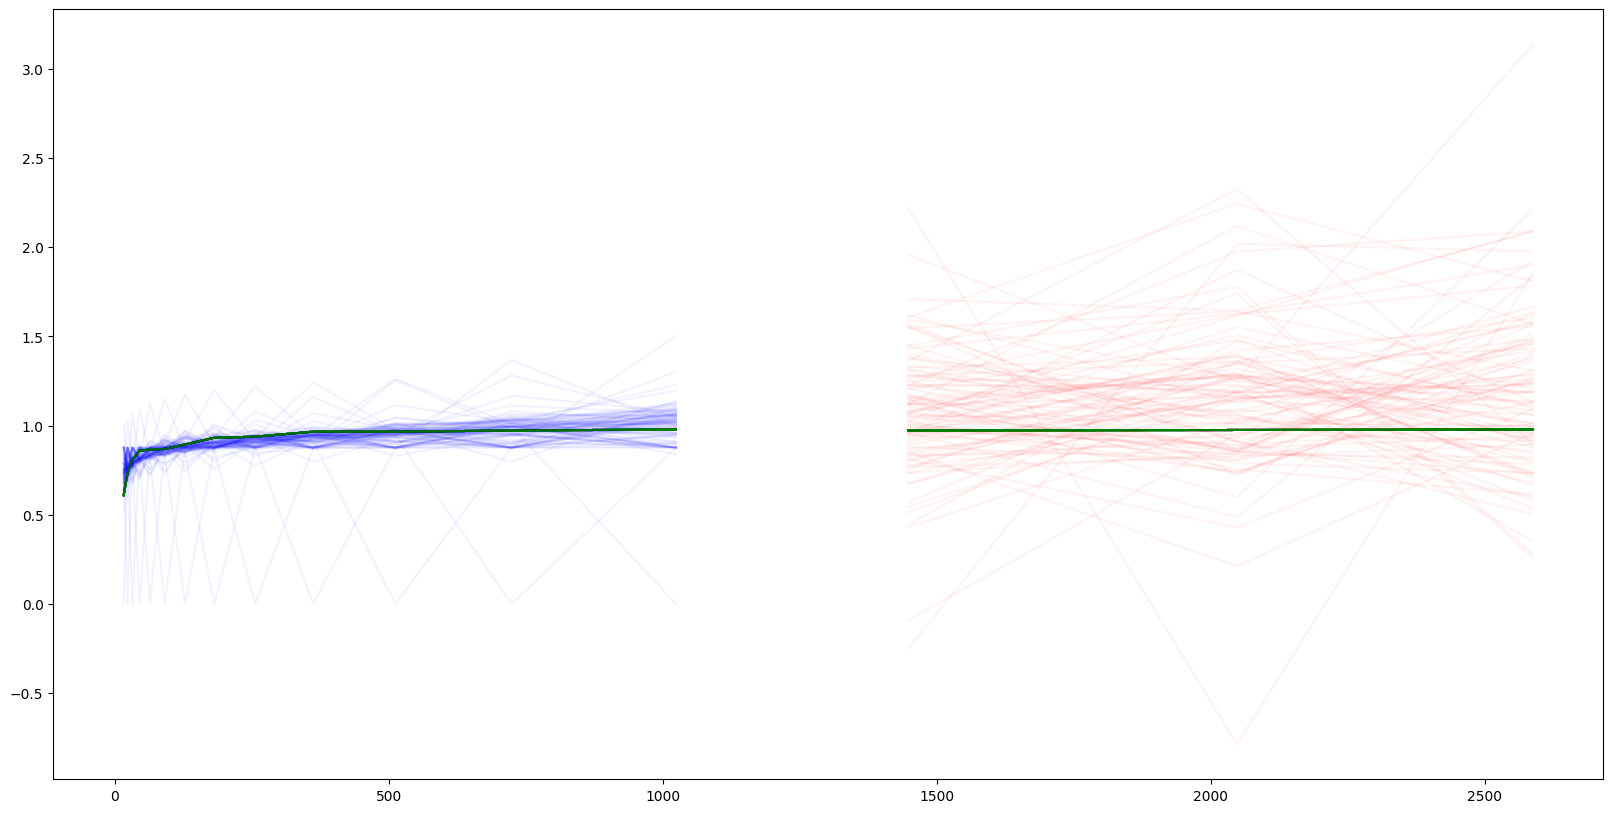

In [123]:
from matplotlib import pyplot as plt
fitted = combined(x_train, weights, torch.exp(best_theta))
fitted_max_abs_diff = torch.max(torch.abs(fitted - y_train), 1).values
fitted = fitted.detach().numpy()

pred = combined(x_test, weights, torch.exp(best_theta))
# add noise with std = fitted_max_abs_diff
pred = pred + torch.randn_like(pred) * fitted_max_abs_diff.reshape(-1, 1)
pred = pred.detach().numpy()

# large figure
plt.figure(figsize=(20, 10))
for i in range(num_samples):
    alpha = 0.05
    plt.plot(x_train[i], fitted[i], 'b', alpha=alpha)
    plt.plot(x_test[i], pred[i], 'r', alpha=alpha)
    plt.plot(x_train[i], y_train[i], 'g', alpha=alpha)
    plt.plot(x_test[i], y_test[i], 'g', alpha=alpha)